In [2188]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import linear_model
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')

In [2189]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

<AxesSubplot:>

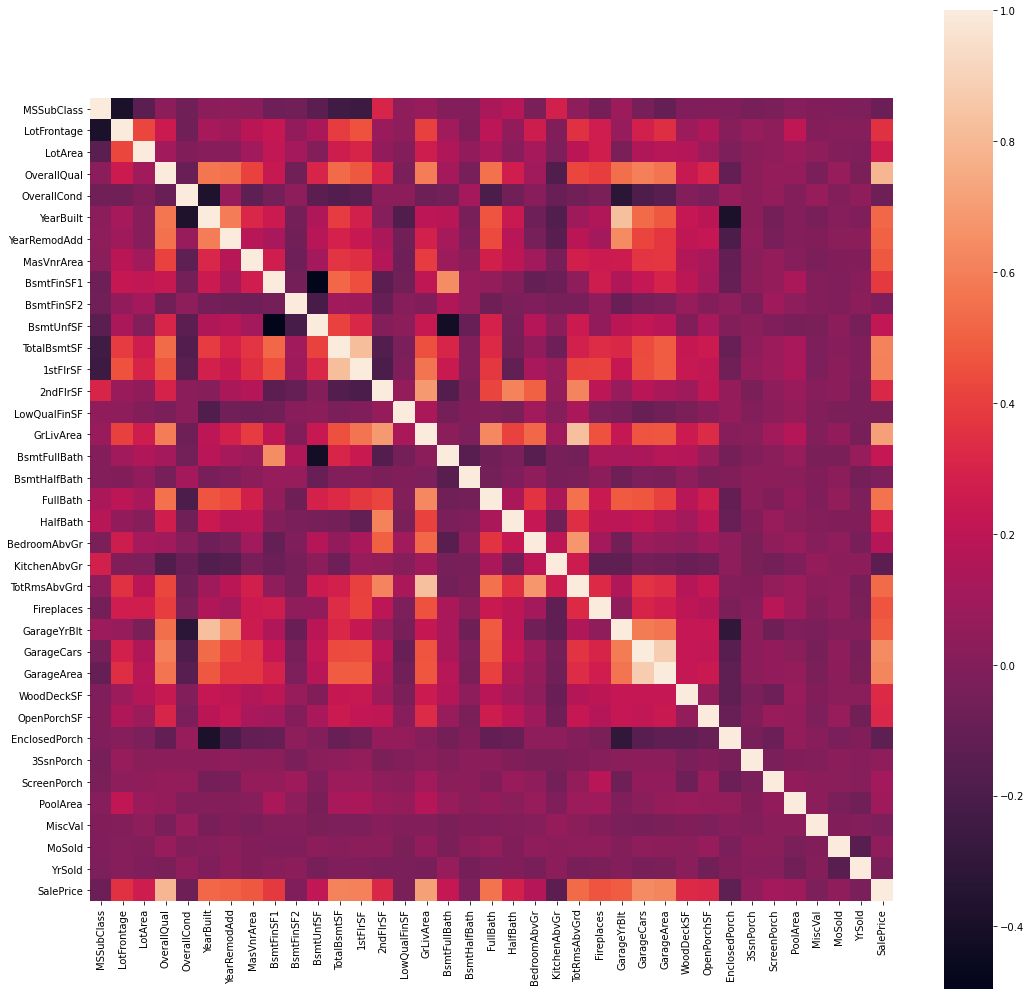

In [2190]:
# Corr for original train data
temp = []
for index, val in train.dtypes.items():
    if index != 'Id':
        temp.append(index)
heatmapTemp = train[temp]
heatmapData = heatmapTemp.corr()
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(heatmapData, vmax=1, square=True)

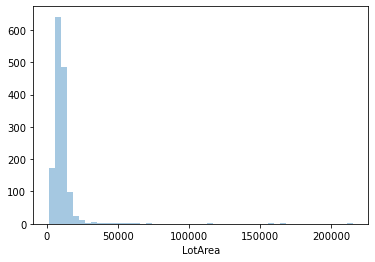

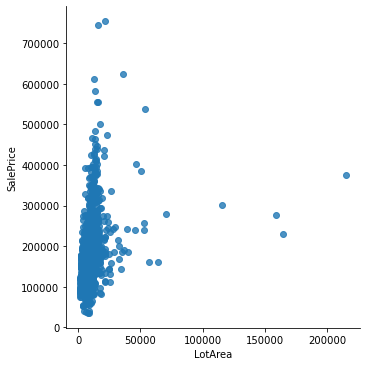

In [2191]:
sns.distplot(train['LotArea'], kde=False)
plt.show()

sns.lmplot('LotArea', 'SalePrice', train, fit_reg=False)
plt.show()

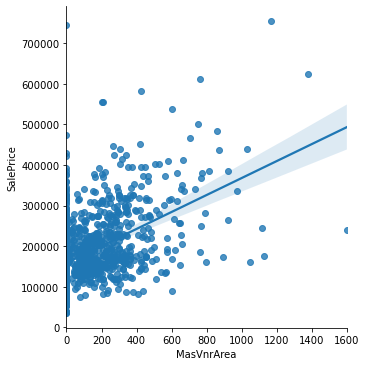

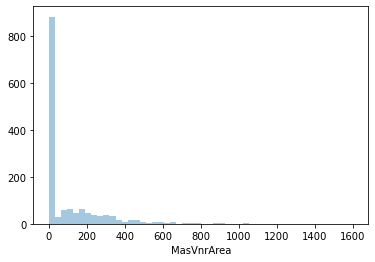

In [2192]:
sns.lmplot('MasVnrArea', 'SalePrice', train, fit_reg=True)
plt.show()
sns.distplot(train['MasVnrArea'], kde=False)
plt.show()

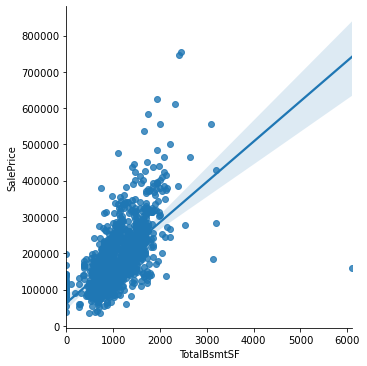

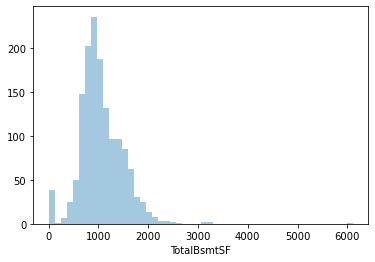

In [2193]:
sns.lmplot('TotalBsmtSF', 'SalePrice', train, fit_reg=True)
plt.show()
sns.distplot(train['TotalBsmtSF'], kde=False)
plt.show()

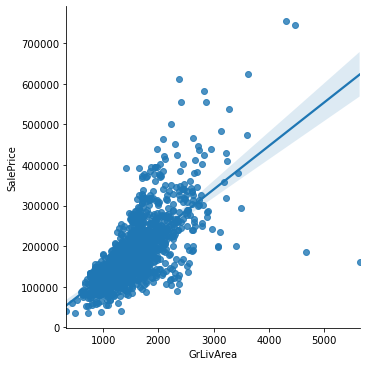

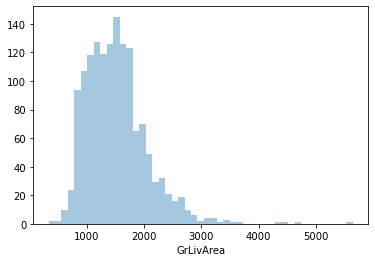

In [2194]:
sns.lmplot('GrLivArea', 'SalePrice', train, fit_reg=True)
plt.show()
sns.distplot(train['GrLivArea'], kde=False)
plt.show()

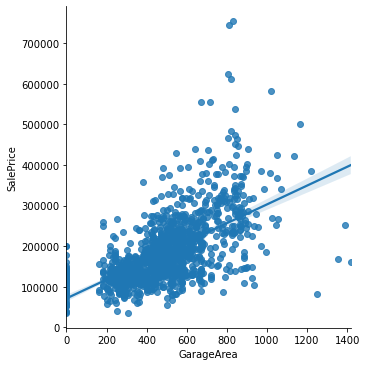

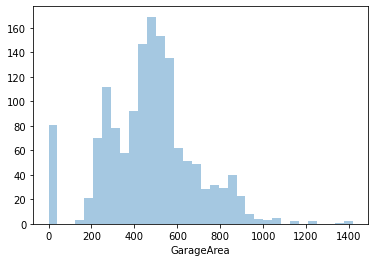

In [2195]:
sns.lmplot('GarageArea', 'SalePrice', train, fit_reg=True)
plt.show()
sns.distplot(train['GarageArea'], kde=False)
plt.show()

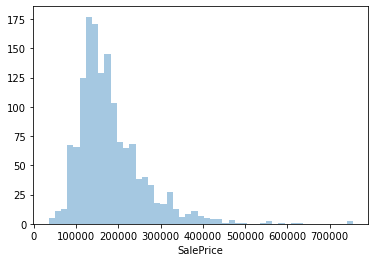

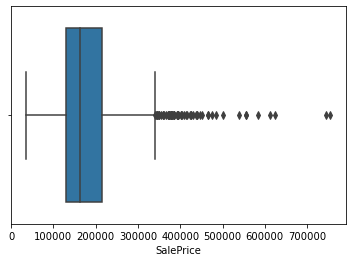

In [2196]:
sns.distplot(train['SalePrice'], kde=False)
plt.show()
sns.boxplot(train['SalePrice'])
plt.show()

In [2197]:
# Tableau 分析结果如下
# 地理位置影响价格
# 2004年之后建造的房子价格有明显升高
# 翻修年份长短貌似对价格影响不大
# 价格分布: Noridge 有两个异常值
#          Northridge，Northridge Heights和Stone Brook平均价格较高


In [2198]:
# Delete two extreme values
train = train.drop((train.query("SalePrice > 700000")).index)

In [2199]:
train1 = train.copy(deep=True)
test1 = test.copy(deep=True)

In [2200]:
total = pd.concat([train1, test1], axis=0)
del total['SalePrice']
del total['Id']

In [2201]:
total['MSSubClass'] = total['MSSubClass'].astype('str')

In [2202]:
# House age
total['HouseAge'] = total.apply(lambda x:2019 - x['YearBuilt'], axis=1)

# Recent live years
total['RecentLivYrs'] = total.apply(lambda x:2019 - x['YrSold'], axis=1)

In [2203]:
total['RebuiltAge'] = total.apply(lambda x:x['YearRemodAdd'] - x['YearBuilt'], axis=1)

In [2204]:
total['Period'] = pd.cut(total.YearBuilt, [1870, 1900, 1920, 1940, 1960, 1980, 2000, 2010], labels=['19ctr', '20s', '40s', '60s', '80s', '00s', 'now'])
total['Period'] = total['Period'].astype('str')

In [2205]:
total['GarageYrBlt'] = total['GarageYrBlt'].astype('str')
total['GarageYrBlt'] = total.apply(lambda x: x['YearBuilt'] if x['GarageYrBlt'] == 'nan' else x['GarageYrBlt'], axis=1)
total['GarageYrBlt'] = total['GarageYrBlt'].astype('float64')
total['GarageYrBlt'] = total['GarageYrBlt'].astype('int')

total['GarageAge'] = total.apply(lambda x:2019 - x['GarageYrBlt'], axis=1)

In [2206]:
OverallQual = {
    "10": "Very Excellent",
    "9": "Excellent",
    "8": "Very Good",
    "7": "Good",
    "6": "Above Average",
    "5": "Average",
    "4": "Below Average",
    "3": "Fair",
    "2": "Poor",
    "1": "Very Poor"
}

OverallCond = {
    "10": "Very Excellent",
    "9": "Excellent",
    "8": "Very Good",
    "7": "Good",
    "6": "Above Average",
    "5": "Average",
    "4": "Below Average",
    "3": "Fair",
    "2": "Poor",
    "1": "Very Poor"
}

# Overall score
total['OverallScore'] = total.apply(lambda x : (x['OverallQual'] + x['OverallCond'])/2, axis=1)
total['OverallQual'] = total['OverallQual'].astype('str')
total['OverallCond'] = total['OverallCond'].astype('str')

total['OverallQual'] = total['OverallQual'].apply(lambda x: OverallQual[x])
total['OverallCond'] = total['OverallCond'].apply(lambda x: OverallCond[x])

In [2207]:
# Delete rich null values and few deviation columns
del total['Alley']
del total['PoolQC']
del total['Fence']
del total['MiscFeature']
del total['FireplaceQu']
del total['Street']
del total['Utilities']

# Delete unused columns
del total['YearBuilt']
del total['YearRemodAdd']
del total['GarageYrBlt']
del total['YrSold']
del total['OverallQual']
del total['OverallCond']

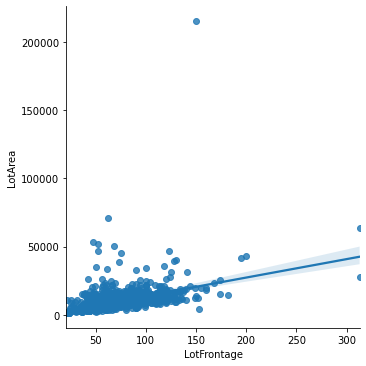

In [2208]:
# Process null value for LotFrontage
sns.lmplot('LotFrontage', 'LotArea', total, fit_reg=True)
plt.show()

na_rows = total[total['LotFrontage'].isnull()]
temp = total[total['LotFrontage'].notnull()]

model = linear_model.LinearRegression()
model.fit(temp['LotArea'].values.reshape(-1,1), temp['LotFrontage'].values.reshape(-1,1))
# lotfrt = model.predict(na_rows['LotArea'].values.reshape(-1,1))

total['LotFrontage'] = total.apply(lambda x : x['LotArea']*model.coef_[0][0]+model.intercept_[0] if math.isnan(x['LotFrontage']) else x['LotFrontage'], axis=1)

In [2209]:
# Process MSZoning
# 根据观察缺失数据的Neighborhood为IDOTRR和Mitchel，训练集中这两个区域的MSZoning值为C,RL,RM。由于lotArea较大，所以大概率为RL。
total['MSZoning'].fillna('RL', inplace=True)

In [2210]:
# Process Exterior1st and Exterior1st
total['Exterior1st'].fillna('Wd Sdng', inplace=True)
total['Exterior2nd'].fillna('Wd Sdng', inplace=True)

In [2211]:
# Process MasVnrType
t1 = total.copy(deep=True)
dummies = ['LotShape', 
           'LandContour', 
           'LotConfig', 
           'LandSlope', 
           'Neighborhood', 
           'Condition1', 
           'Condition2', 
           'BldgType', 
           'HouseStyle',
           'RoofStyle',
           'RoofMatl', 
           'Exterior1st',
           'Exterior2nd']
for feature in dummies:
    dummy_features = pd.get_dummies(t1[feature], prefix='mastype')
    for dummy in dummy_features:
        t1[dummy] = dummy_features[dummy]
        
filter_col = [col for col in t1 if col.startswith('mastype')]
t1_1 = t1[t1['MasVnrType'].notna()]
t1_2 = t1[t1['MasVnrType'].isna()]
MasVnrType = {'BrkFace':1, 'None':2, 'BrkCmn':3, 'Stone':4}
MasVnrType1 = {v: k for k, v in MasVnrType.items()}
t1_1['MasVnrType'] = t1_1['MasVnrType'].apply(lambda x : MasVnrType[x])

clf = DecisionTreeClassifier()
clf = clf.fit(t1_1[filter_col].values, t1_1['MasVnrType'].values.reshape(-1,1))
y_pred = clf.predict(t1_2[filter_col].values)

# Assign the predicted values to NA values
total.loc[total.MasVnrType.isna(), ['MasVnrType']] = y_pred

total['MasVnrType'] = total['MasVnrType'].apply(lambda x : MasVnrType1[x] if x in [1,2,3,4] else x)

In [2212]:
# Process MasVnrArea
mean1 = total.query("MasVnrType == 'BrkFace'")['MasVnrArea'].mean()
mean2 = total.query("MasVnrType == 'Stone'")['MasVnrArea'].mean()
total['MasVnrArea'].fillna(-1, inplace=True)
total['MasVnrArea'] = total.apply(lambda x : 0 if x['MasVnrType'] == 'None' else x['MasVnrArea'], axis=1)
total['MasVnrArea'] = total.apply(lambda x : mean1 if x['MasVnrType'] == 'BrkFace' and x['MasVnrArea'] == -1 else x['MasVnrArea'], axis=1)
total['MasVnrArea'] = total.apply(lambda x : mean2 if x['MasVnrType'] == 'Stone' and x['MasVnrArea'] == -1 else x['MasVnrArea'], axis=1)

In [2213]:
# Process Bsmt features
total['TotalBsmtSF'].fillna(0, inplace=True)
total['BsmtFinSF1'] = total.apply(lambda x : 0 if x['TotalBsmtSF'] == 0 else x['BsmtFinSF1'], axis=1)
total['BsmtFinSF2'] = total.apply(lambda x : 0 if x['TotalBsmtSF'] == 0 else x['BsmtFinSF2'], axis=1)
total['BsmtUnfSF'] = total.apply(lambda x : 0 if x['TotalBsmtSF'] == 0 else x['BsmtUnfSF'], axis=1)
total['BsmtQual'].fillna('unkown', inplace=True)
total['BsmtCond'].fillna('unkown', inplace=True)
total['BsmtExposure'].fillna('unkown', inplace=True)
total['BsmtFinType1'].fillna('unkown', inplace=True)
total['BsmtFinType2'].fillna('unkown', inplace=True)
total['BsmtFullBath'].fillna(0, inplace=True)
total['BsmtHalfBath'].fillna(0, inplace=True)

In [2214]:
total['Electrical'].fillna('SBrkr', inplace=True)
total['KitchenQual'].fillna('TA', inplace=True)
total['Functional'].fillna('Typ', inplace=True)

In [2215]:
# Process Garage features
total['GarageCars'].fillna(0, inplace=True)
total['GarageArea'].fillna(0, inplace=True)
total['GarageType'].fillna('unkown', inplace=True)
total['GarageFinish'].fillna('unkown', inplace=True)
total['GarageQual'].fillna('unkown', inplace=True)
total['GarageCond'].fillna('unkown', inplace=True)

In [2216]:
# Process SaleType
total['SaleType'].fillna('WD', inplace=True)

In [2217]:
# Nb average price
df1 = train.groupby(['Neighborhood']).agg({'GrLivArea':'sum', 'SalePrice':'sum'})
df1 = df1.reset_index()
df1['AvgPrice'] = df1.SalePrice/df1.GrLivArea
df1.drop(['GrLivArea', 'SalePrice'], inplace=True, axis=1)
total = pd.merge(total, df1, on=['Neighborhood'])

In [2218]:
# Print all the columns contain null value
null_cols = total.isnull().any()
for index, val in null_cols.items():
    if val:
        num = total[index].isnull().sum()
        print(index, '/',num, '/',num/total[index].shape[0])

In [2219]:
# Split train/test data after processing
f_train = total[:-len(test)]
f_test = total[-len(test):]
f_train = pd.concat([f_train, train['SalePrice']], axis=1)

In [2220]:
# 生成哑变量
for index, val in f_train.dtypes.items():
    if str(val) in ['object', 'Category']:
        dummy_features = pd.get_dummies(f_train[index], prefix=index)
        f_train = pd.concat([f_train, dummy_features], axis=1)
        del f_train[index]
for index, val in f_test.dtypes.items():
    if str(val) in ['object', 'Category']:
        dummy_features = pd.get_dummies(f_test[index], prefix=index)
        f_test = pd.concat([f_test, dummy_features], axis=1)
        del f_test[index]
        
# 归一化 
scaler = MinMaxScaler()
f_train = pd.DataFrame(scaler.fit_transform(f_train), columns=f_train.columns, index=f_train.index)
f_test = pd.DataFrame(scaler.fit_transform(f_test), columns=f_test.columns, index=f_test.index)

In [2221]:
f_train.to_csv('f_train.csv', index=False)
f_test.to_csv('f_test.csv', index=False)

In [2222]:
# Apply XGboost
y = f_train['SalePrice'].values.reshape(-1,1)
del f_train['SalePrice']
X = f_train.values
X_submit = f_test.values

# Splitting 
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123) 
  
xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)   

# xgb_r.fit(train_X, train_y)    
# pred = xgb_r.predict(test_X) 
# rmse = np.sqrt(MSE(test_y, pred)) 
# print("RMSE : % f" %(rmse))

In [2223]:
# Submission
# xgb_r.fit(X, y)
# f_pred = xgb_r.predict(X_submit)